# Лабораторная работа № 4. Латентное размещение Дирихле

In [1]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [2]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [3]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Dr. Mandeville (Christopher Lee) and his sister Sarah (Joan Collins) try to locate two suitcases of money hidden on the large estate of one of his former patients but their plans are thwarted when mentally unstable Andrew (Robert Hardy) arrives to claim the estate which had been left to him by the owner before he died. Andrew soon begins to have flashbacks to the murders committed by the previous owner Edward (Hardy as well). As the story unfolds it sheds light on the events of 30 years or so before when Edward had planned to leave his wife Victoria (Jean Marsh) for the younger and more attractive governess of their two children. In desperaration Victoria had encouraged the two children to murder the governess whilst she attempted to seduce Edward in the bedroom. In a fit of rage Edward strangled his wife and killed the children with a sword before bricking all four corpses up behind a wall with the two cases of money.
Andrew eventually kills Dr. Mandeville and Sarah with a pick axe be

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [4]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [7]:
print(data.sample(1).values[0])

dharmayya naidu vijayakumar is an underworld kingpin who lost his wife because he is uneducated hence he want to felicitate education in his seema area by constructing school he realizes that the quarry he owns ha good quality granite deposit samba ntr is dharmayya naidu son pasupathi prakash raj is dharmayya naidu pasupathi play the game in such a way that dharmayya naidu is forced to give granite quarry a a dowry to pasupathi family due to which dharmayya naidu daughter commits suicide when samba come to know the reason behind his sister suicide he occupies the quarry and kill pasupathi brother pasupathi kill everybody in samba house in retaliation samba and his nemesis pasupathi take shelter in kanchi and amritsir respectively a police ban them from entering ap for a year samba settle a a saree manufacturer and trader in kanchi tamil nadu the rest of the story is all about how he return to seema and take vengeance against pasupathi and then start serving in educational field


Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

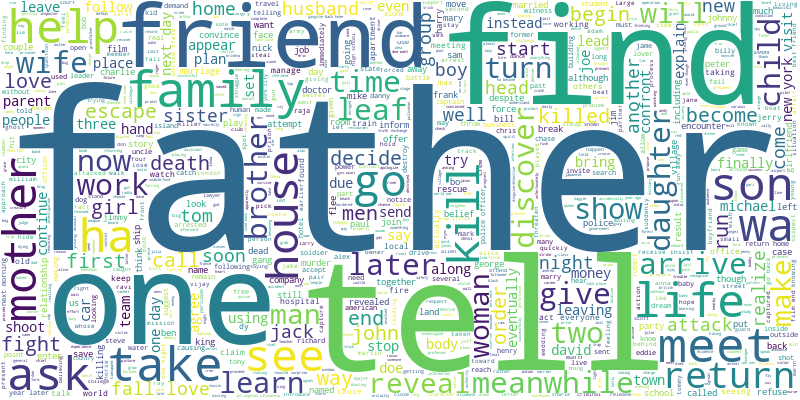

In [8]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/isabellad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

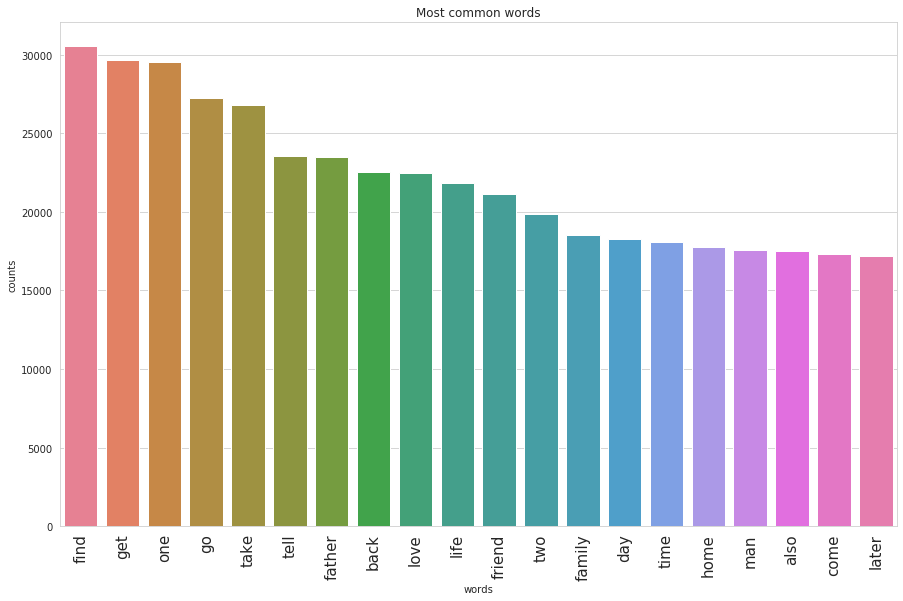

In [13]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [14]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [15]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=10, verbose=2, n_jobs=-1, random_state=42)
doc_topic_distr = lda.fit_transform(count_data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.1s remaining:   38.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.9s remaining:   32.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   29.7s remaining:   29.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   26.3s remaining:   26.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   23.5s remaining:   23.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   27.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   22.7s remaining:   22.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   25.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   22.0s remaining:   22.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   25.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   20.2s remaining:   20.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   23.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   20.2s remaining:   20.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   23.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.3s remaining:   21.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   23.0s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.0s remaining:   21.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   19.0s remaining:   19.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   22.6s finished


In [16]:
print_topics(count_vectorizer, lda.components_, 10)


Topic #0
joe find harry back one tell father take peter see

Topic #1
max jack escape one find agent kill team attempt take

Topic #2
police kill murder gang killed one officer film find case

Topic #3
police find car go get tell house back take one

Topic #4
ship one king soldier kill men army escape attack battle

Topic #5
life friend new school film one go tell love home

Topic #6
money get love father new family charlie steve go take

Topic #7
love get father family life come son friend go one

Topic #8
tom jerry war back anna take german men bill get

Topic #9
michael john paul tell find town henry go house back


**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

### Распределение документов по темам

#### Встречаемость тем в документах

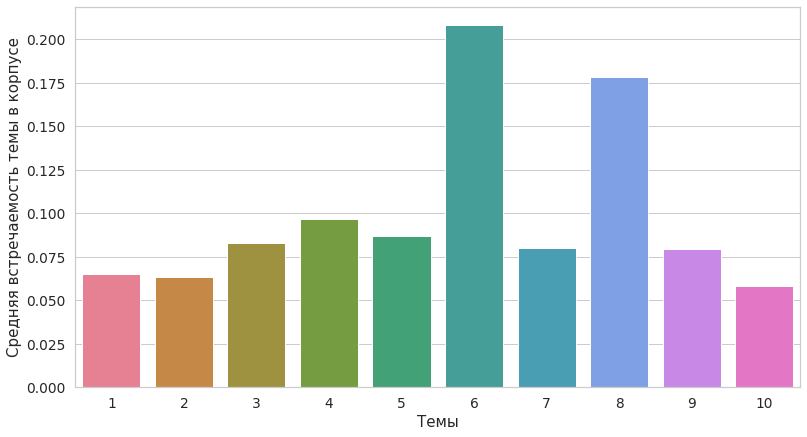

In [20]:
plt.figure(figsize=(13, 7))
plt.xlabel("Темы")
plt.ylabel("Средняя встречаемость темы в корпусе")
sns.barplot(list(range(1, 1+doc_topic_distr.shape[1])), np.mean(doc_topic_distr, axis=0), palette='husl')

#### Распределение каждой темы в документе

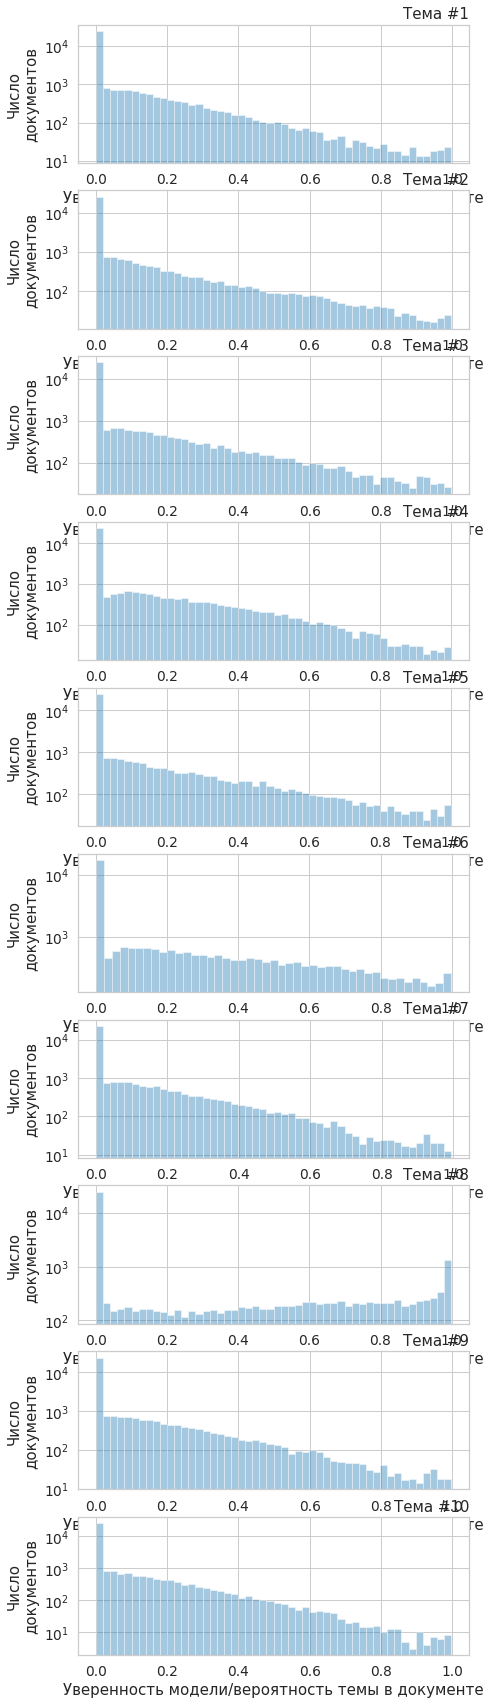

In [21]:
n = doc_topic_distr.shape[1]
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(7, 3*n))
for i, ax in enumerate(axes):
    ax.set_title("Тема #"+str(i+1), loc='right')
    ax.set_ylabel("Число\nдокументов")
    ax.set_xlabel("Уверенность модели/вероятность темы в документе")
    sns.distplot(doc_topic_distr[:, i], ax=ax, hist=True, kde=False, hist_kws={'log': True})
#     ax.set_xscale("log")

Заметно, что тема с порядковым номером 6 и 8 встречается в большом числе документов. Посмотрим на модель 8 более подробно

In [22]:
components = lda.components_
voc = count_vectorizer.vocabulary_
inv_voc = {i: word for word, i in voc.items()}

In [23]:
# Встречаемость самых частых слов корпуса в темах
word_counts = np.squeeze(np.asarray(count_data.sum(axis=0)))
top_words = np.argsort(word_counts)[::-1]
top_words_freq = word_counts[top_words] / np.sum(word_counts)
[inv_voc[i] for i in top_words[:10]]

['find', 'get', 'one', 'go', 'take', 'tell', 'father', 'back', 'love', 'life']

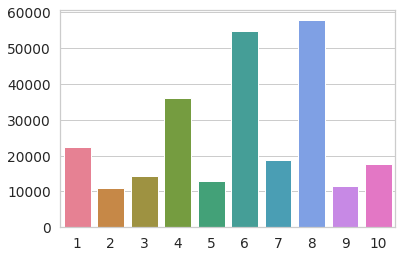

In [24]:
# Посмотрим на количество слов из топа 10 в каждой теме
top_10_words = top_words[:10]
top_words_components = components[:, top_10_words] #*top_words_freq[top_10_words][None, :]
sns.barplot(list(range(1, 1+10)), np.sum(top_words_components, axis=1), palette='husl')

Видно, что для 6 и 8-ая темы выделяется. В этой теме наибольшее количество часто-встречающихся слов. Однако я не думаю, что можно сказать, что эта тема "мусорная", так как вполне возможно, что многие фильмы в выборке про романтику и тому подобное.

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

$$
p(W, T| \Phi, \pi) = \prod\limits_{d, t}(\pi_t \prod\limits_n \Phi_{tW_{dn}})^{[t=t_d]} \\
$$
Вывод формул для E-шага
$$
q(T) = p(T| W, \Phi, \pi) = \dfrac{p(W, T| \Phi, \pi)}{\int p(W, T| \Phi, \pi) dT} \\
q(t_d = k) = \dfrac{\pi_k \prod\limits_n \Phi_{kW_{dn}}}{\sum\limits_t \pi_t \prod\limits_n \phi_{tW_{dn}}} = \mu_{dk}
$$

Вывод формул для M-шага
$$
\mathbb{E}_{q(T)} \log p(W, T|\Phi, \pi) \rightarrow \max_{\Phi, \pi}, \quad \sum\limits_i \pi_i = 1 \quad \{\sum\limits_w \Phi_{tw} = 1\}_{t=1}^{T}\\
\mathbb{E}_{q(T)} \log p(W, T|\Phi, \pi) = \mathbb{E} \bigg\{ \sum\limits_{d, t}(\log\pi_t + \sum\limits_{n, w}[w = w_{dn}]\Phi_{tw}) \bigg\} =\\
\sum\limits_{d, t} \mu_{dt} \big( \log\pi_t + \sum\limits_{n, w}[w = w_{dn}]\Phi_{tw} \big)
$$

Вывод формулы для $\pi_t$
$$
L = \sum\limits_{d, t} \mu_{dt}\log\pi_t + \lambda (\sum\limits_i \pi_i - 1) \\
\dfrac{\partial L}{\partial \pi_t} = 0 \rightarrow ... \rightarrow \pi_t = \dfrac{\sum\limits_d \mu_{dt}}{\mathcal{Z}} = \dfrac{\sum\limits_d \mu_{dt}}{\sum\limits_{dk} \mu_{dk}}
$$

Вывод формулы для $\Phi_{tw}$
$$
L = \sum\limits_{d,t} \mu_{dt} \big( \sum\limits_{n, w}[w = w_{dn}]\log\Phi_{tw} \big) + \sum\limits_t \lambda_t (\sum_w \Phi_{tw} - 1) \\
\dfrac{\partial L}{\partial \Phi_{tw}} = 0 \\
\Phi_{tw} = \dfrac{\sum\limits_{d, n}[w = w_{dn}]\mu_{dt}}{\mathcal{Z}}
\Phi_{tw} = \dfrac{\sum\limits_{d, n}[w = w_{dn}]\mu_{dt}}{\sum\limits_d \mu_{dt} N_d}
$$

ELBO
$$
ELBO = \mathbb{E}_{q(T)} \log \dfrac{P(W, T|\Phi, \pi)}{q(T)} = \sum\limits_{d, t} \mu_{dt} \big( \log\pi_t + \sum\limits_{n, w}[w = w_{dn}]\Phi_{tw} -
\log \mu_{dt}\big)
$$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [25]:
def print_stat(var, name):
    print("statistics for variable", name)
    print(np.sum(var == 0), var.min(), var.max(), var.mean(), np.sum(np.isnan(var)), np.quantile(var, 0.5))
    
def print_shape(var, name):
    print(f"Shape of value {name} is", var.shape)

class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5, n_iter=10):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        self.n_iter = n_iter
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(self.n_iter):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
        return self
            
    def _initialize(self, bow):
        n_docs, V = bow.shape
        self.mu = np.empty((n_docs, self.n_topics))  # matrix with shape [n_docs, n_topics]
        self.pi = np.abs(np.random.randn(self.n_topics))  # prior on topics
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))  # [n_topics, n_vocs]
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        n_docs, V = bow.shape        
        log_phi = np.log(self.phi + self.epsilon)
        
        for k in range(self.n_topics):
            log_phi_k = np.expand_dims(log_phi[k, :], axis=0)  # [1, n_voc]
            self.mu[:, k] = np.array(bow.multiply(log_phi_k).sum(axis=1))[:, 0]  # [n_doc, ]
            
        self.mu += np.log(self.pi)[None, :]
        self.mu = np.exp(self.mu - np.max(self.mu, axis=1)[:, None])
        self.mu = self.mu / self.mu.sum(axis=1)[:, None]
        
    def _m_step(self, bow):
        n_docs, V = bow.shape
        self.pi = np.sum(self.mu, axis=0)
        self.pi = self.pi / n_docs  # np.sum(self.pi)
        
        for k in range(self.n_topics):
            mu_k = np.expand_dims(self.mu[:, k], axis=1)  # [n_docs, 1]
            self.phi[k, :] = np.array(bow.multiply(mu_k).sum(axis=0))[0]  # np.sum(mu_k * bow, axis=1)
            
        self.phi = self.phi / np.sum(self.phi, axis=1)[:, None]
        
    def _count_elbo(self, bow):
        n_doc, n_voc = bow.shape
        
        # documnent - topic matrix, shape = [n_docs, n_topics]
        # one in topic to which document belongs 
        phi_term = np.empty_like(self.mu)  # [n_doc, n_topics]
        log_phi = np.log(self.phi + self.epsilon)
        
        for k in range(self.n_topics):
            log_phi_k = np.expand_dims(log_phi[k, :], axis=0)  # [1, n_voc]
            phi_term[:, k] = np.array(bow.multiply(log_phi_k).sum(axis=1))[:, 0]
                        
        pi_ = np.expand_dims(self.pi, axis=0)
        elbo = np.sum( self.mu*(np.log(pi_) + phi_term - np.log(self.mu+self.epsilon)) )
            
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

Оказывается, что есть документы, для которых нет слов из словаря

In [28]:
n_topics = 10
simple_LDA = SimpleLDA(n_topics, n_iter=100)
simple_LDA.fit(count_data)


0:
 elbo: -56092518.268670134
 increase: inf

1:
 elbo: -55889881.19414427
 increase: 202637.07452586293

2:
 elbo: -55640959.61275884
 increase: 248921.58138543367

3:
 elbo: -55406333.752294675
 increase: 234625.86046416312

4:
 elbo: -55271010.31484893
 increase: 135323.43744574487

5:
 elbo: -55211334.46242459
 increase: 59675.85242433846

6:
 elbo: -55174531.04778489
 increase: 36803.41463970393

7:
 elbo: -55150866.82901862
 increase: 23664.218766264617

8:
 elbo: -55136528.11016495
 increase: 14338.718853674829

9:
 elbo: -55126632.19077023
 increase: 9895.91939471662

10:
 elbo: -55119196.463921614
 increase: 7435.726848617196

11:
 elbo: -55113841.48460437
 increase: 5354.979317240417

12:
 elbo: -55109300.27601183
 increase: 4541.208592541516

13:
 elbo: -55105575.78565462
 increase: 3724.4903572127223

14:
 elbo: -55102716.61247711
 increase: 2859.1731775105

15:
 elbo: -55100300.535808615
 increase: 2416.0766684934497

16:
 elbo: -55097313.468422495
 increase: 2987.0673861

In [29]:
print_topics(count_vectorizer, simple_LDA.phi, 10)


Topic #0
love get father life family one come friend take go

Topic #1
one find police take go kill man get tell back

Topic #2
go tell friend get father find one love life day

Topic #3
find one take back tell return father love get rama

Topic #4
find go one tell get take back home house father

Topic #5
get go love take new find one back tell father

Topic #6
one find two go take back get time life new

Topic #7
one find take back kill escape two return men go

Topic #8
tom jerry find one back go tell take get house

Topic #9
find one tell life love go father friend take film



**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия?

In [30]:
### YOUR CODE HERE ###
count_vectorizer2 = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.1)
bow2 = count_vectorizer2.fit_transform(data)

n_topics = 10
simple_LDA2 = SimpleLDA(n_topics, n_iter=100)
simple_LDA2.fit(bow2)


0:
 elbo: -43537601.717467204
 increase: inf

1:
 elbo: -43392794.34613883
 increase: 144807.37132837623

2:
 elbo: -43297216.03450145
 increase: 95578.31163737923

3:
 elbo: -43173282.39117807
 increase: 123933.64332337677

4:
 elbo: -43000662.60255589
 increase: 172619.78862217814

5:
 elbo: -42857765.238955095
 increase: 142897.36360079795

6:
 elbo: -42799880.49518838
 increase: 57884.74376671761

7:
 elbo: -42774065.57955218
 increase: 25814.915636196733

8:
 elbo: -42754819.15524548
 increase: 19246.424306698143

9:
 elbo: -42741593.7335081
 increase: 13225.421737380326

10:
 elbo: -42731166.409198456
 increase: 10427.324309647083

11:
 elbo: -42721074.34765335
 increase: 10092.061545103788

12:
 elbo: -42712583.75463813
 increase: 8490.593015223742

13:
 elbo: -42705961.612639405
 increase: 6622.141998723149

14:
 elbo: -42700055.86330846
 increase: 5905.749330945313

15:
 elbo: -42694099.97923825
 increase: 5955.884070210159

16:
 elbo: -42687604.5354737
 increase: 6495.443764

In [31]:
print_topics(count_vectorizer2, simple_LDA2.phi, 10)


Topic #0
war german ship american captain british army jack soldier team

Topic #1
village raja ravi vijay raj rao college kumar movie singh

Topic #2
michael john sam david peter sex apartment student couple kate

Topic #3
john team game king billy alex joe ben sam play

Topic #4
jack nick danny michael john team ben hospital charlie joe

Topic #5
mary john joe tom york david george play mike jack

Topic #6
rama bruce joe master prince fire power soldier king battle

Topic #7
gang gun john frank prison shot joe johnny crime charlie

Topic #8
paul student king war army inside soldier charlie village human

Topic #9
tom jerry bug earth alien ship jack human power team
